This code largely follows the work of github user purnasi at https://github.com/purnasai/Dino_V2/blob/main/2.PCA_visualization.ipynb .

In [1]:
# Imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms


import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

DINOv2 expects images to be a multiple of 14 (the patch size). It was trained at 224x244 and then the final 10k train runs were run at 516x516. The smallest distilled model, `dinov2_vits14` has a feature dimension of 384. They also normalize the data before feeding it into the model. We do the same here, adding an unnormalize option for visualizing.

In [2]:
IMG_SIZE: int = 518
RESIZE_DIM: int = IMG_SIZE + 2
PATCH_SIZE: int = 14
FEAT_DIM: int = 384 # for vits
PATCH_W: int = IMG_SIZE // PATCH_SIZE
PATCH_H: int = IMG_SIZE // PATCH_SIZE

transform = transforms.Compose([           
    transforms.Resize(RESIZE_DIM),
    transforms.CenterCrop(IMG_SIZE),            
    transforms.ToTensor(),                    
    transforms.Normalize(mean=0.5, std=0.2)
])

unnormalize = transforms.Normalize(
    mean=-0.5 / 0.2,
    std=1 / 0.2
)

to_img = transforms.ToPILImage()

Load model here. Add '_lc' to load the ImageNet 1k linear classifier version, but we just want the features.

In [3]:
dinov2_vits14: nn.Module  = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()
dinov2_vits14.cuda()
pass # here to flush stdout

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [4]:
def get_img_features(img_tensor: torch.Tensor, model: Any) -> np.ndarray:
    # feed (processed) img tensor into DINOV2, get the features and detach
    features_dict = model.forward_features(img_tensor.unsqueeze(0))
    features = features_dict["x_norm_patchtokens"]
    return features.detach().cpu().numpy()

In [5]:
class PlotParams(TypedDict): # little helper class for typed plotting
    colour: str
    title: str

plane_params: PlotParams = {'colour': 'C0', 'title': 'Plane'}
sketch_params: PlotParams = {'colour': 'C1', 'title': 'Sketch'}
sofc_params: PlotParams = {'colour': 'C2', 'title': 'SOFC'}

plot_params: List[PlotParams] = [plane_params, sketch_params, sofc_params]

In [6]:
def normalise_pca(pca: np.ndarray) -> np.ndarray:
    # normalize each component of the pca individually
    out = np.zeros_like(pca)
    n_components: int = pca.shape[-1]
    for i in range(n_components):
        c = pca[:, i]
        amax, amin = np.amax(c), np.amin(c)
        out[:, i] = (c - amin) / (amax - amin)
    return out

def normalize_pca_img(pca_img: np.ndarray) -> np.ndarray:
    # Assume C, H, W
    out = np.zeros_like(pca_img)
    n_components: int = pca_img.shape[-1]
    for i in range(n_components):
        c = pca_img[:, :, i]
        amax, amin = np.amax(c), np.amin(c)
        out[:, :, i] = (c - amin) / (amax - amin)
    return out

def load_image(path: str, transform: transforms.Compose) -> Tuple[torch.tensor, Image.Image]:
    # Load image with PIL, convert to tensor by applying $transform, and invert transform to get display image
    image = Image.open(path).convert("RGB")
    tensor = transform(image)
    transformed_img = to_img(unnormalize(tensor))
    return tensor, transformed_img

def get_pca_features(feat_arr: np.ndarray, n_patches_h: int, n_patches_w: int, feat_dim: int, n_components:int =3) -> np.ndarray:
    #  Take np array output of DINOv2 and compute $n_components principal components.
    reshaped_features: np.ndarray = feat_arr.reshape(n_patches_h * n_patches_w, feat_dim)
    pca = PCA(n_components=n_components)
    pca.fit(reshaped_features)
    pca_features = pca.transform(reshaped_features)
    return pca_features

def plot_pca_hists(pcas: List[np.ndarray], plot_params: List[PlotParams], n_components: int=3, show_first: bool=True) -> None:
    # Loop through each of the pcas, plot an image of the pcas and the distributions of the first 3 components.
    n_imgs = len(pcas)
    n_plots = n_components + 1 if show_first is True else n_components
    fig, axs = plt.subplots(n_imgs, n_plots)
    fig.set_size_inches(12, 4)
    fig.tight_layout()
    for i in range(n_imgs):
        params = plot_params[i]
        for j in range(n_plots):
            ax: plt.axes.Axes = axs[i, j] if n_imgs > 1 else axs[j]
            if j == 0 and show_first: # draw first component spatially
                normed = normalise_pca(pcas[i])
                ax.set_title(params['title'])
                ax.imshow(normed[:, :].reshape(PATCH_H, PATCH_W, 3))
                ax.set_axis_off()
            else: # plot hist
                component = pcas[i][:, j - 1]
                ax.hist(component, bins=20, color=params['colour'])
                if i == 0:
                    ax.set_title(f"PCA Component {j}")

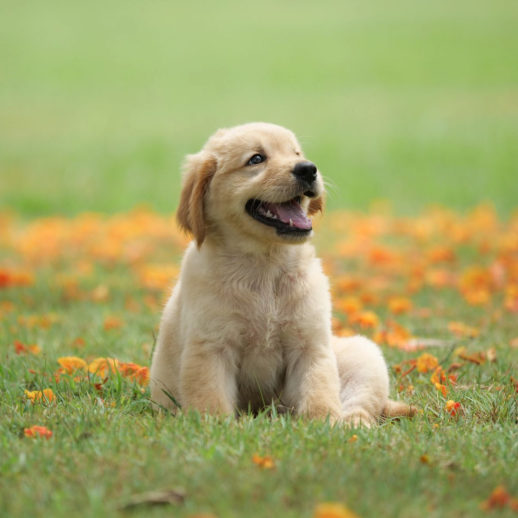

In [7]:
plane_tensor, plane_img = load_image("dog.jpg", transform)
plane_tensor = plane_tensor.to('cuda')

sofc_tensor, sofc_img = load_image("sofc.png", transform)
sofc_tensor = sofc_tensor.to('cuda')

sketch_tensor, sketch_img = load_image("sketch.jpg", transform)
sketch_tensor = sketch_tensor.to('cuda')
plane_img

In [8]:
pcas: List[np.ndarray] = []

for tensor in [plane_tensor, sketch_tensor, sofc_tensor]:
    dino_features_arr = get_img_features(tensor, dinov2_vits14)
    pca_features_arr = get_pca_features(dino_features_arr, PATCH_H, PATCH_W, FEAT_DIM)
    pcas.append(pca_features_arr)

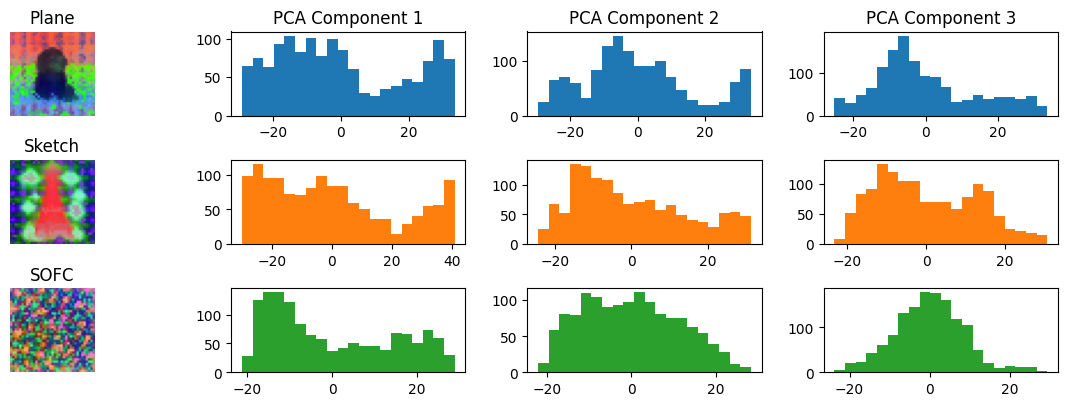

In [9]:
plot_pca_hists(pcas, plot_params)

Paper and repo above suggest the 1st PCA component tends to be the foreground/background distinction, and that the minima in the histogram is the cutoff point. Here we threshold the 1st component of the plane PCA and confirm that. 

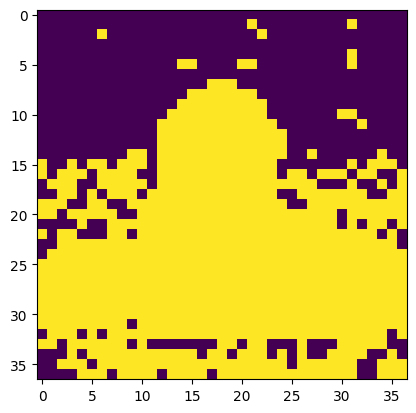

In [29]:
FG_THRESHOLD = 0 # from histograms
fg = pcas[0][:, 0] < FG_THRESHOLD
plt.imshow(fg.reshape(PATCH_H, PATCH_W))

In [11]:
features_dict = dinov2_vits14.forward_features(plane_tensor.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 37, 37]) torch.Size([1369, 3])
(518, 518, 3)


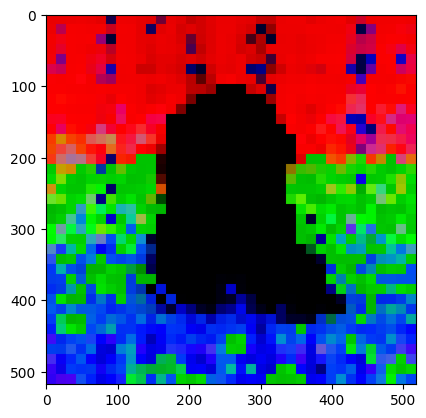

In [12]:
from high_res import PCA as pPCA

features_dict = dinov2_vits14.forward_features(plane_tensor.unsqueeze(0))
features = features_dict["x_norm_patchtokens"]

test_pca = pPCA(3)
#U, S, V = torch.pca_lowrank(features, q=3)
#proj = torch.matmul(features, V)
proj = test_pca.fit_transform(features.squeeze(0))
proj = torch.nn.functional.normalize(proj)
low_res_patches = proj.reshape(1, 3, PATCH_H, PATCH_W)
print(low_res_patches.shape, proj.shape)

upsample_weight = torch.ones((3, 3, 14, 14), device='cuda')
#with torch.no_grad(): #PROBLEM IS THE UPSAMPLING NOT DOING WHAT I EXPECT 
    #upscaled = torch.nn.functional.interpolate(low_res_patches, scale_factor=(PATCH_SIZE, PATCH_SIZE), mode='nearest-exact')
    #downscaled = torch.nn.functional.interpolate(upscaled, scale_factor=(1/PATCH_SIZE, 1/PATCH_SIZE), mode='nearest-exact')

kron = torch.kron(proj.reshape(PATCH_H, PATCH_W, 3), torch.ones((14, 14, 1), device='cuda'))
#kron = torch.kron(low_res_patches, torch.ones((1, 14, 14,), device='cuda'))

upscaled_numpy = kron.detach().cpu().squeeze(0).numpy() #.transpose(1, 2, 0)
print(upscaled_numpy.shape)
#downscaled_numpy = downscaled.cpu().squeeze(0).numpy()

low_res_numpy = low_res_patches.detach().cpu().squeeze(0).numpy().reshape(PATCH_H, PATCH_W, 3)
#high_res_numpy = upscaled_numpy.reshape(IMG_SIZE, IMG_SIZE, 3)[:16, :16]

plt.imshow(upscaled_numpy.transpose(0, 1, 2))


In [34]:
from high_res import HighResDV2

shifts = [i for i in range(1, 14, 1)]

net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", n_components=3,)
net.cuda()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


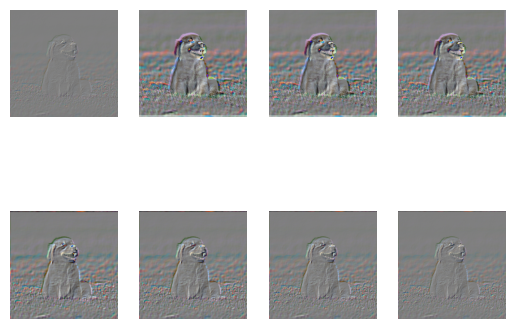

In [31]:
shifted_img_tensors = net.get_shifted_img_batch(plane_tensor).detach().cpu()
fig, axs = plt.subplots(2, 4)
#fig.tight_layout()
for i in [0, 1, 2, 3, -4, -3, -2, -1]:
    row, col = i // 4, i % 4
    img = to_img(unnormalize(shifted_img_tensors[-i, :, :, :]- plane_tensor.cpu())) #- plane_tensor.cpu()
    ax = axs[row, col]
    ax.set_axis_off()
    ax.imshow(img)

In [35]:
high_res_plane_features = net(plane_tensor).detach().cpu().squeeze(0).numpy()[:3, :, :]

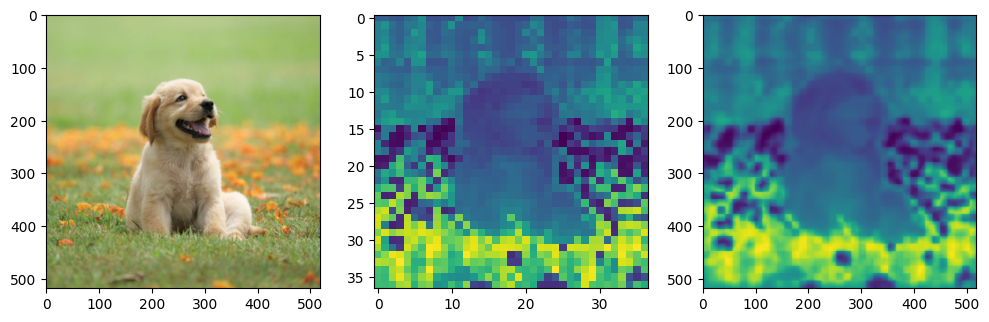

In [36]:
high_res_img = high_res_plane_features.transpose(1, 2, 0)
normed = normalize_pca_img(high_res_img)
#print(normed[:10, :10, :3])
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
low_res_features = normalise_pca(pcas[0])[:, 2].reshape(PATCH_H, PATCH_W, 1)
axs[0].imshow(plane_img)
axs[1].imshow(low_res_features)
axs[2].imshow(normed[:, :, 2])

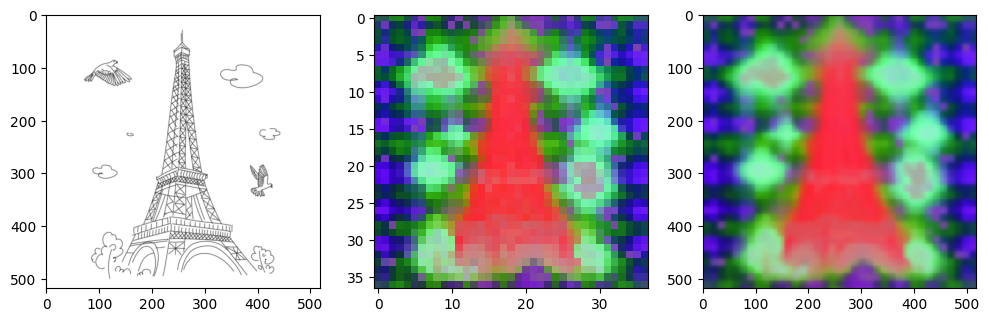

In [17]:
high_res_sketch_features = net(sketch_tensor).detach().cpu().squeeze(0).numpy()[:3, :, :]
high_res_img = high_res_sketch_features.transpose(1, 2, 0)
normed = normalize_pca_img(high_res_img)
#print(normed[:10, :10, :3])
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
low_res_features = normalise_pca(pcas[1])[:, :].reshape(PATCH_H, PATCH_W, 3)
axs[0].imshow(sketch_img)
axs[1].imshow(low_res_features)
axs[2].imshow(normed[:, :, :], interpolation=None)


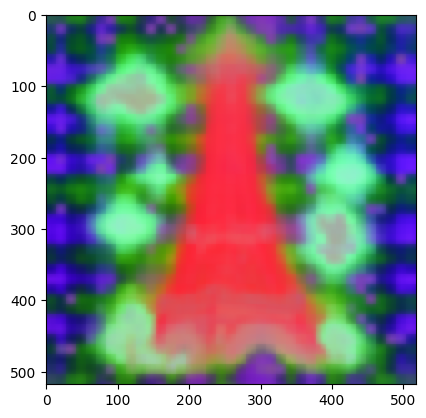

In [18]:
plt.imshow(normed[:, :, :])

(array([34961., 39521., 35520., 39357., 28131., 21211., 13080.,  8267.,
        17122., 31154.]),
 array([-29.67153931, -22.68250465, -15.69347095,  -8.7044363 ,
         -1.71540225,   5.27363205,  12.2626667 ,  19.25170135,
         26.2407341 ,  33.22977066,  40.21880341]),
 <BarContainer object of 10 artists>)

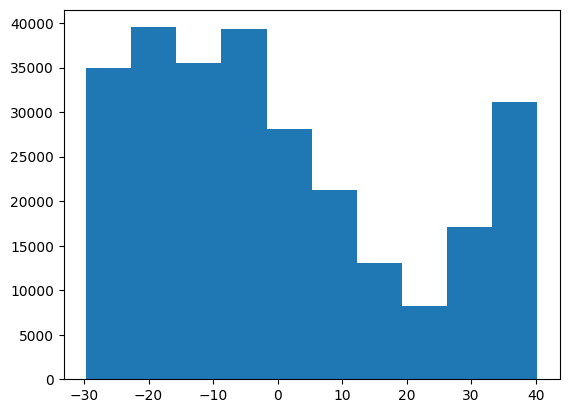

In [19]:
plt.hist(high_res_img[:, :, 0].flatten())

(518, 518, 3)


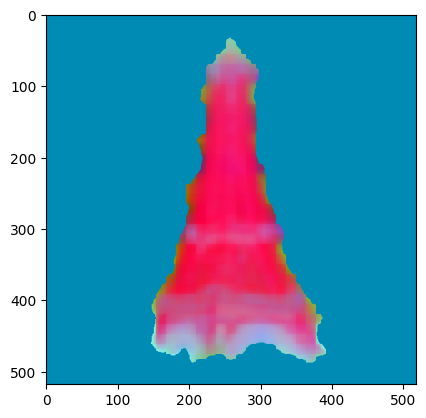

In [20]:
sketch_fg_mask = (high_res_img[:, :, 0] > 20).reshape(IMG_SIZE, IMG_SIZE, 1)
normed_fg = normalize_pca_img(high_res_img * sketch_fg_mask)
print(normed_fg.shape)
plt.imshow(normed_fg)
#plt.hist(normed_fg.flatten())

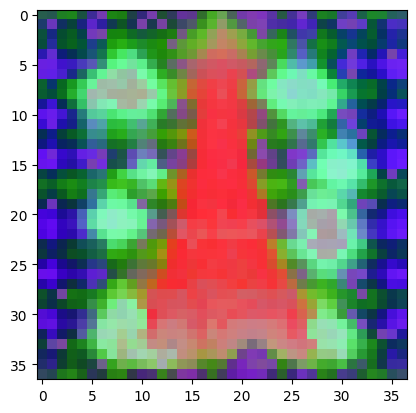

In [21]:
plt.imshow(low_res_features)

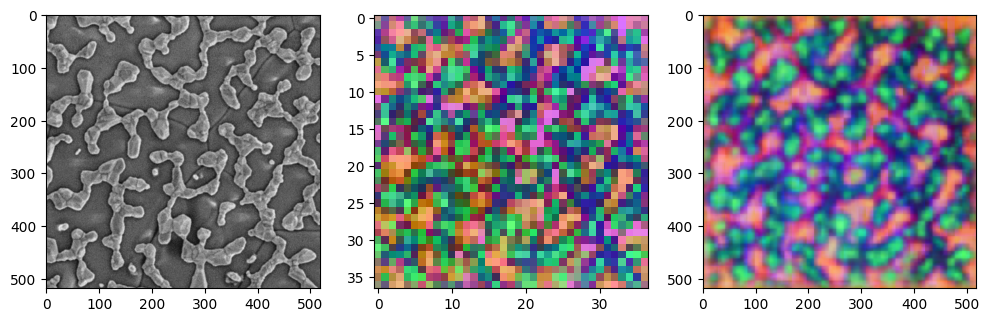

In [22]:
high_res_sofc_features = net(sofc_tensor).detach().cpu().squeeze(0).numpy()[:3, :, :]
high_res_img = high_res_sofc_features.transpose(1, 2, 0)
normed = normalize_pca_img(high_res_img)
#print(normed[:10, :10, :3])
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
low_res_features = normalise_pca(pcas[2])[:, :].reshape(PATCH_H, PATCH_W, 3)
axs[0].imshow(sofc_img)
axs[1].imshow(low_res_features)
axs[2].imshow(normed[:, :, :])

In [23]:
high_res_pcas = []